In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
from difflib import get_close_matches
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Scikit-learn: Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# Scikit-learn: Model Selection and Metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize # Grouped with metrics as it's often used for ROC/AUC with multiclass

# Scikit-learn: Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Other ML Libraries
import xgboost as xgb
from xgboost import XGBClassifier # Explicitly import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier # Explicitly import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

# Dimensionality Reduction
from sklearn.decomposition import TruncatedSVD

# Optimization
import optuna


#####################
##Optuna parameters##
#####################
n_trials_FR = 1
n_trials_XGB = 1


In [4]:
def age_groups(df):
    """
    Create age groups based on the 'Age' column.
    """
    bins = [0, 12, 18, 30, 50, 100]
    labels = ['Child', 'Teen', 'Young Adult', 'Adult', 'Senior']
    df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
    return df

In [5]:
def apply_tfidf_svd(df, text_column, max_features=1000, n_components=5):
    vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')
    vectors = vectorizer.fit_transform(df[text_column])
    svd = TruncatedSVD(n_components)
    x_sv = svd.fit_transform(vectors)
    tfidf_df = pd.DataFrame(x_sv)
    cols = [(text_column + "_tfidf_" + str(f)) for f in tfidf_df.columns.to_list()]
    tfidf_df.columns = cols
    df = df.reset_index(drop=True)
    df = pd.concat([df, tfidf_df], axis="columns")
    return df


In [6]:
def feature_engineer_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Performs feature engineering and imputation on the input DataFrame.

    This function creates new features from existing ones and fills in missing
    values based on logical rules and relationships within the data.

    Args:
        df: The input pandas DataFrame with the original data.

    Returns:
        The transformed pandas DataFrame.
    """
    # --- Feature Creation ---
    
    # Create 'Total_bill' by summing all expenditure columns
    expenditure_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df['Name'].fillna('Uknown Unknow', inplace=True)  # Ensure 'Name' column is not null for string operations
    df['Total_bill'] = df[expenditure_cols].sum(axis=1)

    # Split 'Cabin' into 'Cabin_level', 'Cabin_number', and 'Cabin_type'
    df['Cabin'].fillna('Uknown/Uknown/Uknown', inplace=True)  # Ensure 'Cabin' column is not null for string operations
    df['Cabin_level'] = df['Cabin'].str.split('/', expand=True)[0]
    df['Cabin_number'] = df['Cabin'].str.split('/', expand=True)[1]
    df['Cabin_number'] = pd.to_numeric(df['Cabin_number'], errors='coerce')
    #df['Cabin_bin_simple'] = (df['Cabin_number'] // 300).astype('Int64').astype(str)
    df['Cabin_type'] = df['Cabin'].str.split('/', expand=True)[2]

    # Split 'Name' into 'First_name' and 'Last_name'
    df['First_name'] = df['Name'].str.split(' ', expand=True)[0]
    df['Last_name'] = df['Name'].str.split(' ', expand=True)[1]

    # --- Data Imputation ---

    # Impute 'CryoSleep' based on total spending
    # If a passenger spent money, they weren't in CryoSleep.
    # If they spent nothing, they likely were.
    df.loc[(df['Total_bill'] > 0) & (df['CryoSleep'].isnull()), 'CryoSleep'] = False
    df.loc[(df['Total_bill'] == 0) & (df['CryoSleep'].isnull()), 'CryoSleep'] = True

    # Impute 'HomePlanet' using family name (Last_name)
    # This assumes people with the same last name likely share a HomePlanet.
    if df['HomePlanet'].isnull().any():
        lastname_homeplanet_map = df.groupby('Last_name')['HomePlanet'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)
        unique_homeplanet_lastnames = df.groupby('Last_name')['HomePlanet'].nunique()
        reliable_lastnames = unique_homeplanet_lastnames[unique_homeplanet_lastnames == 1].index
        reliable_map = lastname_homeplanet_map.loc[reliable_lastnames]
        
        missing_homeplanet_mask = df['HomePlanet'].isnull()
        df.loc[missing_homeplanet_mask, 'HomePlanet'] = df.loc[missing_homeplanet_mask, 'Last_name'].map(reliable_map)

    # Impute 'VIP' status based on HomePlanet and CryoSleep status
    df.loc[(df['HomePlanet'] == 'Earth') & (df['VIP'].isnull()), 'VIP'] = False
    df.loc[(df['CryoSleep'] == True) & (df['VIP'].isnull()), 'VIP'] = False


    ########################################
    #####Last and First Name Imputation#####
    ########################################

    df['Last_name_pop'] = np.where(
        df['Last_name'].map(df['Last_name'].value_counts()) > 5, 
        df['Last_name'], 
        'Rare'
    )

    df['First_name_pop'] = np.where(
            df['First_name'].map(df['First_name'].value_counts()) > 5, 
            df['First_name'], 
            'Rare'
        )

    # Impute expenditure columns for passengers in CryoSleep
    # If a passenger was in CryoSleep, their spending should be zero.
    all_expenditure_cols = expenditure_cols + ['Total_bill']
    df.loc[df['CryoSleep'] == True, all_expenditure_cols] = df.loc[df['CryoSleep'] == True, all_expenditure_cols].fillna(0)

    df = apply_tfidf_svd(df, 'First_name', n_components=5)
    df = apply_tfidf_svd(df, 'Last_name', n_components=5)
    df = apply_tfidf_svd(df, 'Cabin', n_components=5)


    ####################################
    ######Group Size####################
    ####################################
    # New feature - Group
    df['Group'] = df['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
    # New feature - Group size
    df['Group_size']=df['Group'].map(lambda x: pd.concat([df['Group'], df['Group']]).value_counts()[x])


    ####################################
    #######Aditional Columns#############
    ####################################
    # Spending ratios
    df['Luxury_spending_ratio'] = (df['Spa'] + df['VRDeck']) / (df['Total_bill'] + 1)
    df['Food_spending_ratio'] = (df['RoomService'] + df['FoodCourt']) / (df['Total_bill'] + 1)

    # Age groups
    df['Age_group'] = pd.cut(df['Age'], bins=[0, 12, 18, 30, 50, 100], 
                            labels=['Child', 'Teen', 'Young_Adult', 'Adult', 'Senior'])
    
    #Family size based on Last_name
    df['Family_size'] = df['Last_name'].map(df['Last_name'].value_counts())

    # Solo travelers
    df['Solo_traveler'] = (df['Group_size'] == 1).astype(int)
    # Cabin deck indicators (A-G might have significance)
    df['Is_premium_deck'] = df['Cabin_level'].isin(['A', 'B', 'C']).astype(int)
    
    df['Cabin_level_type'] = df['Cabin_level'].astype(str) + '_' + df['Cabin_type'].astype(str)

    return df



In [7]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype

def impute_with_knn(df, col_to_impute, numeric_features, categorical_features, print_progress=False):
    """
    Imputes missing values in a specified column using K-Nearest Neighbors.

    Automatically chooses between KNeighborsRegressor for numeric targets and
    KNeighborsClassifier for categorical (string/object) targets.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        col_to_impute (str): The name of the column to fill missing values in.
        numeric_features (list): A list of numeric column names to use as features.
        categorical_features (list): A list of categorical column names to use as features.

    Returns:
        pd.DataFrame: The DataFrame with the specified column imputed.
    """
    print(f"Imputing column: {col_to_impute}")

    # --- 1. Feature Engineering ---
    # Ensure the column being imputed is not in the feature list
    numeric_features = [col for col in numeric_features if col != col_to_impute]
    categorical_features = [col for col in categorical_features if col != col_to_impute]

    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
    encoded_cats = pd.DataFrame(
        ohe.fit_transform(df[categorical_features]),
        columns=ohe.get_feature_names_out(categorical_features),
        index=df.index
    )
    X = pd.concat([df[numeric_features], encoded_cats], axis=1)
    y = df[col_to_impute]

    # --- 2. Separate Known and Unknown Data ---
    y_known = y.dropna()
    if y_known.empty:
        if print_progress:
            print(f"   -> Skipping. No observed values to learn from.")
        return df

    X_known = X.loc[y_known.index].fillna(0)
    X_unknown = X.loc[y.isna()].fillna(0)
    
    if X_unknown.empty:
        if print_progress:
            print(f"   -> Skipping. No missing values to impute.")
        return df

    # --- 3. Scale Features ---
    scaler = StandardScaler()
    X_known_scaled = scaler.fit_transform(X_known)
    X_unknown_scaled = scaler.transform(X_unknown)

    # --- 4. DYNAMIC MODELING (with the fix for 'object' type) ---
    # Check if the target is categorical (string OR general object)
    if is_string_dtype(y) or y.dtype == 'object':
        if print_progress:
            print(f"   -> Column type is '{y.dtype}'. Using KNeighborsClassifier.")
        model = KNeighborsClassifier(n_neighbors=5)
        model.fit(X_known_scaled, y_known)
        y_pred = model.predict(X_unknown_scaled)
    # Check if the target is numeric
    elif is_numeric_dtype(y):
        if print_progress:
            print(f"   -> Column type is '{y.dtype}'. Using KNeighborsRegressor.")
        model = KNeighborsRegressor(n_neighbors=5)
        model.fit(X_known_scaled, y_known)
        y_pred = model.predict(X_unknown_scaled)
    # Fallback for unsupported types - use mode of non-null values
    else:
        if print_progress:
            print(f"   -> Column type '{y.dtype}' not supported. Using mode of non-null values.")
        mode_value = y_known.mode().iloc[0] if not y_known.mode().empty else y_known.iloc[0]
        y_pred = np.full(len(y_unknown), mode_value)

    # --- 5. Fill in Missing Values ---
    df.loc[y.isna(), col_to_impute] = y_pred
    return df

## Read and Clean Data

In [8]:

##################################################
###################Read Data #####################
##################################################

cd='./'

#gender_subm=pd.read_csv(cd+'gender_submission.csv')
test_df=pd.read_csv(cd+'test.csv')
train_df=pd.read_csv(cd+'train.csv')

y_train_input=train_df['Transported'].astype(int)


train_df= feature_engineer_dataframe(train_df)
cabin_df=train_df[['Transported','Cabin_number']]
train_df.drop(columns=['Transported'], inplace=True)

test_df= feature_engineer_dataframe(test_df)
#test_df.drop(columns=['PassengerId'], inplace=True)


total_df=pd.concat([train_df, test_df],axis=0, ignore_index=True, sort=False)




##################################################
####### Imputation of Missing Values using KNN####
##################################################


# 1. Define your lists of numeric and categorical feature columns
numeric_feature_cols = ['Age', 'Luxury_spending_ratio', 'Food_spending_ratio']
categorical_feature_cols = ['Group', 'Last_name', 'HomePlanet', 'Destination', 'Cabin_level', 'Cabin_type', 'VIP']


# --- MAIN IMPUTATION LOOP ---
# 2. Find which columns have missing values
na_totals = total_df.isnull().sum()
cols_to_process = na_totals[na_totals > 0].index

# 3. Loop through and apply the imputation function
for col in cols_to_process:
    if col not in ['Name','Cabin', 'VIP','First_name','Last_name']:
        total_df = impute_with_knn(
            df=total_df,
            col_to_impute=col,
            numeric_features=numeric_feature_cols,
            categorical_features=categorical_feature_cols
        )

print("\nImputation complete.")



###############################################
#####Final preparation of DataFrame############
###############################################

train_df= total_df[total_df['PassengerId'].isin(train_df['PassengerId'])]
test_df = total_df[total_df['PassengerId'].isin(test_df['PassengerId'])]


######################################
######Columns for Model Training######
######################################

num_cols = ["RoomService", "FoodCourt", "ShoppingMall",  "Spa", "VRDeck", "Total_bill", 'Group_size', 'Luxury_spending_ratio', 'Food_spending_ratio', 'Family_size', 'Cabin_number', 'First_name_tfidf_0', 'First_name_tfidf_1', 'First_name_tfidf_2',
            'First_name_tfidf_3', 'First_name_tfidf_4', 'Last_name_tfidf_0', 'Last_name_tfidf_1', 'Last_name_tfidf_2', 'Last_name_tfidf_3',
            'Last_name_tfidf_4', 'Cabin_tfidf_0', 'Cabin_tfidf_1', 'Cabin_tfidf_2', 'Cabin_tfidf_3', 'Cabin_tfidf_4']

cat_cols = ['Age_group',"CryoSleep", 'Cabin_level', 'Cabin_type', "HomePlanet", "Destination", 'Solo_traveler', 'Is_premium_deck']

train_df.drop(columns=['PassengerId'], inplace=True)
train_df.reset_index(drop=True, inplace=True)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
df_all_encoded = pd.DataFrame(ohe.fit_transform(train_df[cat_cols]), columns=ohe.get_feature_names_out(), index=train_df.index)
train_df_final = pd.concat([train_df[num_cols], df_all_encoded], axis=1)

passenger_ids = test_df['PassengerId']
test_df.drop(columns=['PassengerId'], inplace=True)
test_df.reset_index(drop=True, inplace=True)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
df_all_encoded = pd.DataFrame(ohe.fit_transform(test_df[cat_cols]), columns=ohe.get_feature_names_out(), index=test_df.index)
test_df_final = pd.concat([test_df[num_cols], df_all_encoded], axis=1)  #### X-variable for prediction

Imputing column: HomePlanet
Imputing column: Destination
Imputing column: Age
Imputing column: RoomService
Imputing column: FoodCourt
Imputing column: ShoppingMall
Imputing column: Spa
Imputing column: VRDeck
Imputing column: Cabin_number
Imputing column: Luxury_spending_ratio
Imputing column: Food_spending_ratio
Imputing column: Age_group

Imputation complete.


/tmp/ipykernel_22500/766860438.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=['PassengerId'], inplace=True)
/tmp/ipykernel_22500/766860438.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=['PassengerId'], inplace=True)


## Choose best model after optimization data 

In [11]:
# Classifiers
classifiers = {
    "LogisticRegression" : LogisticRegression(random_state=0),
    "KNN" : KNeighborsClassifier(),
    #"SVC" : SVC(random_state=0, probability=True),
    "RandomForest" : RandomForestClassifier(random_state=0),
    #"LGBM" : LGBMClassifier(random_state=0),
    #"CatBoost" : CatBoostClassifier(random_state=0, verbose=False),
    "NaiveBayes": GaussianNB()
}

# Grids for grid search
LR_grid = {'penalty': ['l1','l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

SVC_grid = {'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [4, 6, 8, 10, 12]}

boosted_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [4, 8, 12],
        'learning_rate': [0.05, 0.1, 0.15]}

NB_grid={'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7]}

# Dictionary of all grids
grid = {
    "LogisticRegression" : LR_grid,
    "KNN" : KNN_grid,
    "SVC" : SVC_grid,
    "RandomForest" : RF_grid,
    "XGBoost" : boosted_grid,
    "LGBM" : boosted_grid,
    "CatBoost" : boosted_grid,
    "NaiveBayes": NB_grid }


i=0
clf_best_params=classifiers.copy()
valid_scores=pd.DataFrame({'Classifer':classifiers.keys(), 'Validation accuracy': np.zeros(len(classifiers)), 'Training time': np.zeros(len(classifiers))})

X_train, X_test, y_train, y_test = train_test_split(train_df_final, y_train_input, test_size=0.35, random_state=42)

for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

    # Train and score
    clf.fit(X_train, y_train)
    valid_scores.iloc[i,1]=clf.score(X_test, y_test)

    # Save trained model
    clf_best_params[key]=clf.best_params_
    
    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i,2]=np.round((stop - start)/60, 2)
    
    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i,2])
    print('')
    i+=1


print(valid_scores.to_markdown())

/home/liutin/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/liutin/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Model: LogisticRegression
Training time (mins): 0.03

Model: KNN
Training time (mins): 0.01

Model: RandomForest
Training time (mins): 0.12

Model: NaiveBayes
Training time (mins): 0.0

|    | Classifer          |   Validation accuracy |   Training time |
|---:|:-------------------|----------------------:|----------------:|
|  0 | LogisticRegression |              0.776865 |            0.03 |
|  1 | KNN                |              0.774893 |            0.01 |
|  2 | RandomForest       |              0.790338 |            0.12 |
|  3 | NaiveBayes         |              0.78048  |            0    |


In [12]:
# Define the objective function
def objective_FR(trial):
    """
    Defines the hyperparameter search space and the model evaluation logic.
    """
    # 1. Create the model using the parameter dictionary

    param_grid_FR = {
    'n_estimators': trial.suggest_int('n_estimators', 50, 750),
    'max_depth': trial.suggest_int('max_depth', 2, 55),
    'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 30),
    'max_features': trial.suggest_categorical('max_features', ['sqrt', None, 'log2']),
    'criterion': trial.suggest_categorical('criterion', ['entropy'])
    }
    
    model = RandomForestClassifier(
        **param_grid_FR,
        random_state=42,
        n_jobs=-1
    )

    # 2. Perform cross-validation and return the mean score
    scores = cross_val_score(model, train_df_final, y_train_input, cv=5, scoring='accuracy', n_jobs=-1)
    return scores.mean()

# Create study and optimize
print("Starting Optuna optimization...")
study = optuna.create_study(direction='maximize')  # We want to maximize accuracy
# I used n_trials=250 here, but for submition I used only 1
study.optimize(objective, n_trials=n_trials_FR)  

# Print results
print(f"Best trial:")
print(f"  Value (accuracy): {study.best_value:.4f}")
print(f"  Best parameters: {study.best_params}")

### Creating final results for Random Forest
model = RandomForestClassifier(
        **study.best_params,
        random_state=42,
        n_jobs=-1
    )
model.fit(train_df_final, y_train_input)

# Predict on training data
y_train_pred_forest = model.predict(test_df_final)

results_df_forest = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Transported': y_train_pred_forest.astype(bool)
})

results_df_forest.to_csv('space_titanic_predictions_Forest.csv', index=False)
print("Predictions saved to 'titanic_predictions_Forest.csv'.")

[I 2025-06-12 16:15:58,360] A new study created in memory with name: no-name-4aa362fe-06fa-4746-b24c-a2d4e8a4b031


Starting Optuna optimization...


NameError: name 'objective' is not defined

In [13]:
import lightgbm as lgb
import optuna
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
import numpy as np

# --- The Ultimate Search: Broad, Robust, and Thorough ---

def objective_broad_robust_search(trial):
    """
    Defines a broad hyperparameter search space and uses a robust
    cross-validation strategy to find a well-generalized model, leveraging GPU.
    """
    # 1. Define a broad, general-purpose hyperparameter grid.
    param_grid = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 3000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),

        # Allow for both simple and complex trees, letting the regularization
        # parameters do the work of controlling overfitting.
        'num_leaves': trial.suggest_int('num_leaves', 20, 400),
        'max_depth': trial.suggest_int('max_depth', 4, 10),

        # Re-widen the search for regularization parameters. This is key to
        # finding a model that generalizes well.
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 100.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 100.0, log=True),

        # Use broad ranges for feature and data subsampling.
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        
        # Consider max_bin for GPU optimization as per LightGBM docs
        'max_bin': trial.suggest_categorical('max_bin', [15, 63, 255]) 
    }

    # 2. Create the LGBM model with the suggested parameters.
    model = lgb.LGBMClassifier(
        **param_grid,
        random_state=42,
        verbose=-1,
        device='gpu', # <--- Crucial for GPU acceleration
        gpu_use_dp=False # <--- Recommended for most GPUs
    )

    # 3. Use a highly robust cross-validation strategy.
    # For GPU training, it's safer to run folds sequentially to avoid GPU resource conflicts.
    cv_strategy = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    
    # Perform cross-validation on the ENTIRE training dataset.
    scores = cross_val_score(
        model,
        train_df_final,
        y_train_input,
        cv=cv_strategy,
        scoring='accuracy',
        n_jobs=1 
    )
    
    return np.mean(scores)

# --- Execute the Search ---

# Create an Optuna study.
print("\nStarting BROAD and ROBUST Optuna optimization for LGBM (with GPU)...")
print("This will take longer, but the resulting score will be much more trustworthy.")
study_robust = optuna.create_study(direction='maximize')

# Optimize with a high number of trials.
# For single GPU, run trials sequentially to avoid GPU resource contention.
study_robust.optimize(objective_broad_robust_search, n_trials=n_trials_XR, n_jobs=1) # <--- Changed to 1

# Print the final results.
print("\nOptimization Finished!")
print(f"Best trial from the robust search:")
print(f"  Value (Robust CV Accuracy): {study_robust.best_value:.6f}")
print(f"  Best parameters found:")
for key, value in study_robust.best_params.items():
    print(f"    '{key}': {value}")

[I 2025-06-12 16:15:58,718] A new study created in memory with name: no-name-6defd9e1-ca97-4ced-aa84-4cf206b43cfb



Starting BROAD and ROBUST Optuna optimization for LGBM (with GPU)...
This will take longer, but the resulting score will be much more trustworthy.


NameError: name 'n_trials_XR' is not defined

In [14]:
####  They was saved from more iterations of the search, but this is the best found so far.

parameters = {
    'n_estimators': 621,
    'learning_rate': 0.012936722174568344,
    'num_leaves': 288,
    'max_depth': 6,
    'min_child_samples': 14,
    'lambda_l1': 0.007560925557891323,
    'lambda_l2': 0.012214066472269627,
    'feature_fraction': 0.5030338076535149,
    'bagging_fraction': 0.7498166252064917,
    'bagging_freq': 6
}

Training accuracy: 0.8999
Testing accuracy: 0.7952


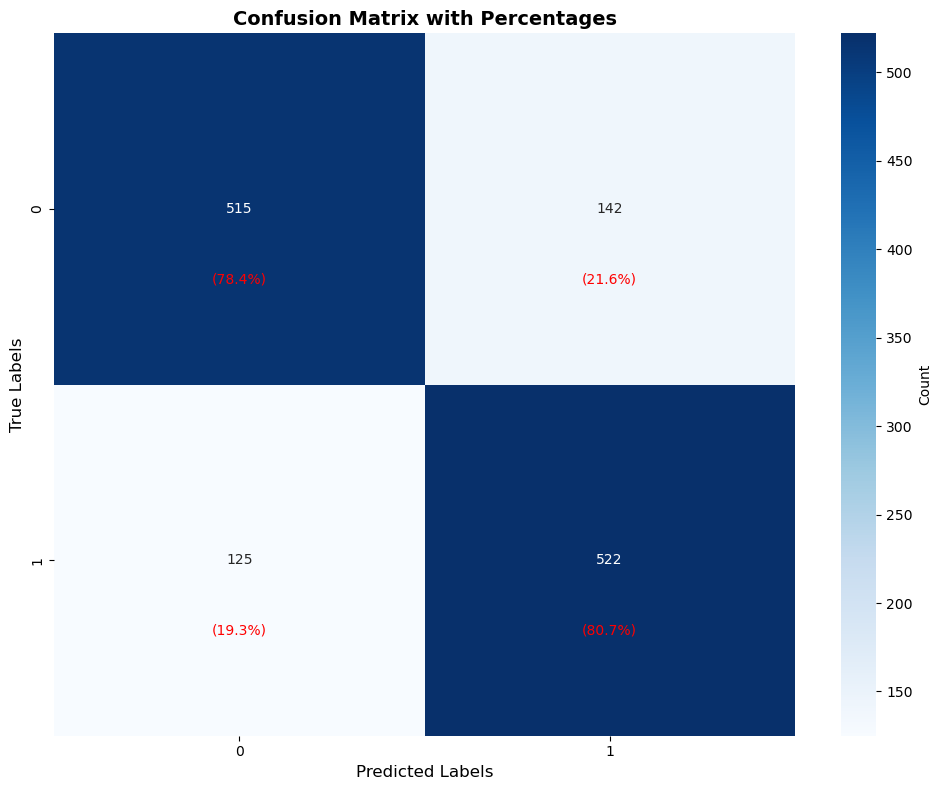

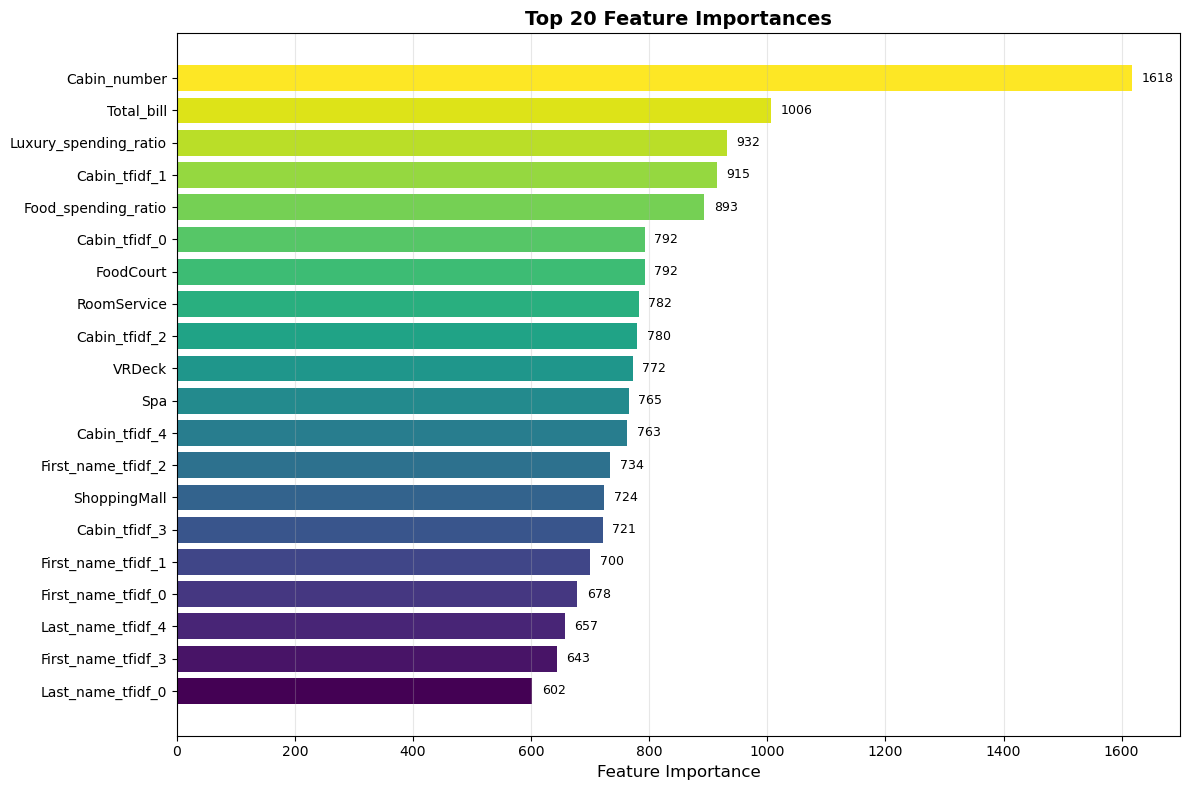

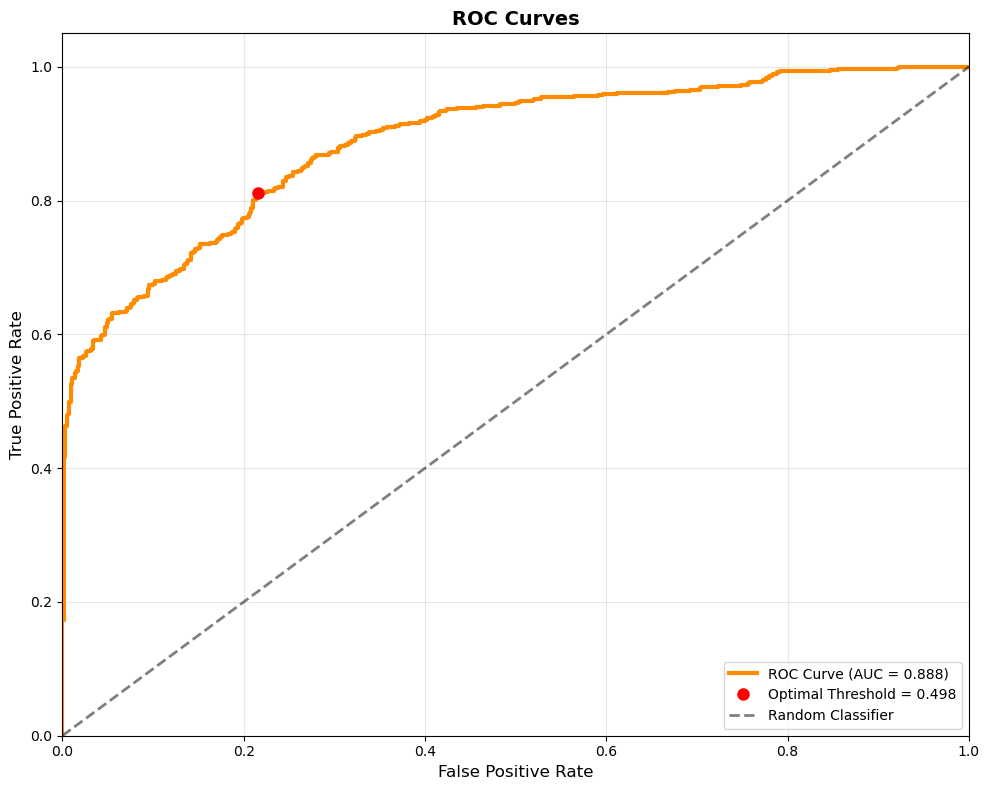


Model Performance Summary:
Training Accuracy: 0.8999
Testing Accuracy: 0.7952
Number of features: 54
Training samples: 7389
Testing samples: 1304


In [15]:
# Your existing code
X_train, X_test, y_train, y_test = train_test_split(train_df_final, y_train_input, test_size=0.15, random_state=42)

final_lgbm_model = lgb.LGBMClassifier(
    **parameters,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
final_lgbm_model.fit(X_train, y_train)

# Predictions
y_train_pred = final_lgbm_model.predict(X_train)
y_test_pred = final_lgbm_model.predict(X_test)
y_test_pred_proba = final_lgbm_model.predict_proba(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Testing accuracy: {test_accuracy:.4f}")

# =============================================================================
# GRAPH 1: CONFUSION MATRIX (Enhanced)
# =============================================================================
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=final_lgbm_model.classes_, 
            yticklabels=final_lgbm_model.classes_,
            cbar_kws={'label': 'Count'})

# Add percentage annotations
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.7, f'({cm_percent[i, j]:.1f}%)', 
                ha='center', va='center', color='red', fontsize=10)

plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix with Percentages', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# =============================================================================
# GRAPH 2: FEATURE IMPORTANCE (Enhanced)
# =============================================================================
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': final_lgbm_model.feature_importances_
}).sort_values('importance', ascending=True).tail(20)  # Top 20 features

# Create horizontal bar plot
bars = plt.barh(range(len(feature_importance)), feature_importance['importance'], 
                color=plt.cm.viridis(np.linspace(0, 1, len(feature_importance))))

# Customize the plot
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Top 20 Feature Importances', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (bar, importance) in enumerate(zip(bars, feature_importance['importance'])):
    plt.text(importance + max(feature_importance['importance']) * 0.01, 
             bar.get_y() + bar.get_height()/2, 
             f'{importance:.0f}', 
             va='center', fontsize=9)

plt.tight_layout()
plt.show()

# =============================================================================
# GRAPH 3: ROC CURVES (Enhanced)
# =============================================================================
plt.figure(figsize=(10, 8))

classes = final_lgbm_model.classes_
n_classes = len(classes)

# Handle binary vs multiclass
if n_classes == 2:
    # Binary classification
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color='darkorange', lw=3, 
             label=f'ROC Curve (AUC = {roc_auc:.3f})')
    
    # Find optimal threshold (Youden's J statistic)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=8,
             label=f'Optimal Threshold = {optimal_threshold:.3f}')
    
else:
    # Multiclass classification
    y_test_bin = label_binarize(y_test, classes=classes)
    colors = plt.cm.Set1(np.linspace(0, 1, n_classes))
    
    # Calculate ROC for each class
    all_fpr = np.unique(np.concatenate([roc_curve(y_test_bin[:, i], y_test_pred_proba[:, i])[0] 
                                       for i in range(n_classes)]))
    
    # Plot ROC curve for each class
    for i, color in zip(range(n_classes), colors):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2,
                 label=f'Class {classes[i]} (AUC = {roc_auc:.3f})')
    
    # Calculate and plot macro-average ROC curve
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_pred_proba[:, i])
        mean_tpr += np.interp(all_fpr, fpr, tpr)
    
    mean_tpr /= n_classes
    mean_auc = auc(all_fpr, mean_tpr)
    plt.plot(all_fpr, mean_tpr, color='navy', linestyle='--', lw=3,
             label=f'Macro-average (AUC = {mean_auc:.3f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5, label='Random Classifier')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nModel Performance Summary:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Number of features: {len(X_train.columns)}")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

In [16]:

print("Training the final tuned LGBM model on the entire dataset...")

# 1. Initialize the final model with the best hyperparameters
final_lgbm_model = lgb.LGBMClassifier(
    **parameters,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# 2. Train the model on all available training data
final_lgbm_model.fit(train_df_final, y_train_input)

# 3. Predict on the final test data (e.g., from a Kaggle competition)
print("Generating predictions on the test dataset...")
y_test_pred_lgbm = final_lgbm_model.predict(test_df_final)

# 4. Create the submission DataFrame in the required format
results_df_lgbm = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Transported': y_test_pred_lgbm.astype(bool) # Ensure the output is boolean
})

# 5. Save the results to a CSV file
output_filename = 'space_titanic_predictions_LGBM.csv'
results_df_lgbm.to_csv(output_filename, index=False)

print(f"Predictions successfully saved to '{output_filename}'.")

Training the final tuned LGBM model on the entire dataset...
Generating predictions on the test dataset...
Predictions successfully saved to 'space_titanic_predictions_LGBM.csv'.
